In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("Set1")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

#### Axis labels
labels = dict(doc=r"Degree of Cure $X \; [-]$",
             Tg=r"Glass Transition Temperature $T_g \; [^\circ C]$",
             temp=r"Temperature $\vartheta \; [^\circ C]$",
             X_max=r"Max. Degree of Cure $X_{\max} \; [-]$",
             time=r"Time $t \; [min]$")

#### Constants
kelvin = 273.15
R = 8.314472

# 02 More Cure Models

_notebook by Nico Liebers, Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

### Cure Modeling of Hexply M21 (Prepreg)


Following the models and parameters from Katz et al:

> James Kratz, Tassos Mesogitis, Alex Skordos, Ian Hamerton, Ivana K. Partridge (2016): _DEVELOPING CURE KINETICS MODELS FOR INTERLEAF PARTICLE TOUGHENED EPOXIES._ In: SAMPE Conference Long Beach 2016

## DiBenedetto's equation for $T_g(X)$

\begin{equation}
T_g(X) = T_{g0} + \frac{(T_{g\infty} - T_{g0}) \cdot \lambda  \cdot  X}{1-(1-\lambda) \cdot X}
\end{equation}

_In paper other variable names are used!_

<IPython.core.display.Javascript object>


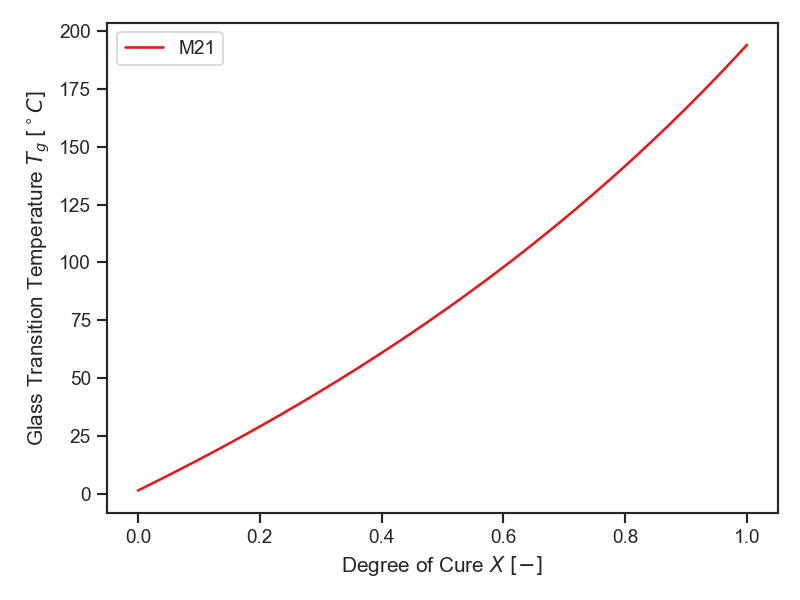

In [2]:
def calc_Tg(X, model_parameters):
    """Calculate current glass transition temperature"""
    Tg0 = model_parameters["Tg0"]
    Tg8 = model_parameters["Tg8"]
    l = model_parameters["lam"]
    return Tg0 + ((Tg8-Tg0)*l*X)/(1-(1-l)*X)

# Values from Katz et al
M21 = dict(Tg0=1.5, Tg8=194, lam=.67)

X = np.linspace(0, 1, 1000)
Tg = calc_Tg(X, M21)

plt.figure()
plt.plot(X, Tg, label="M21")
plt.legend()
plt.xlabel(labels["doc"])
plt.ylabel(labels["Tg"]);
plt.tight_layout();

## Cure Modeling with Arrhenius reaction model

### Reaction Model:

$$
\frac{\mathrm{d} X}{\mathrm{d} t} = k_1 (X_{\max} - X)^l + k_2 X^m (X_{\max} - X)^n
$$

_In paper other variable names are used! (there are also typos)_

### Arrhenius Parameters are calculated by:

$k_i = A_i \exp \left(-\frac{E_{Ai}}{R \cdot T} \right)$

In [3]:
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def reaction_model(X, t, cycle, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    temp = interpol_tempcycle(t, cycle)
    k1, k2 = arrhenius_facors(temp, model_parameters)
    # no relationship for X_max available, so X_max = 1
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = np.max([0, max_X - X])
    return k1 * d_X**l + k2 * X**m * d_X**n

#### Update Model parameters
M21.update(dict(A1=420615, EA1=78890, A2=57440, EA2=68978, l=.8, m=.61, n=3.22))
# no relationship for X_max available, for X_max = 1:
M21.update(dict(a=0, b=-1e9))

<IPython.core.display.Javascript object>


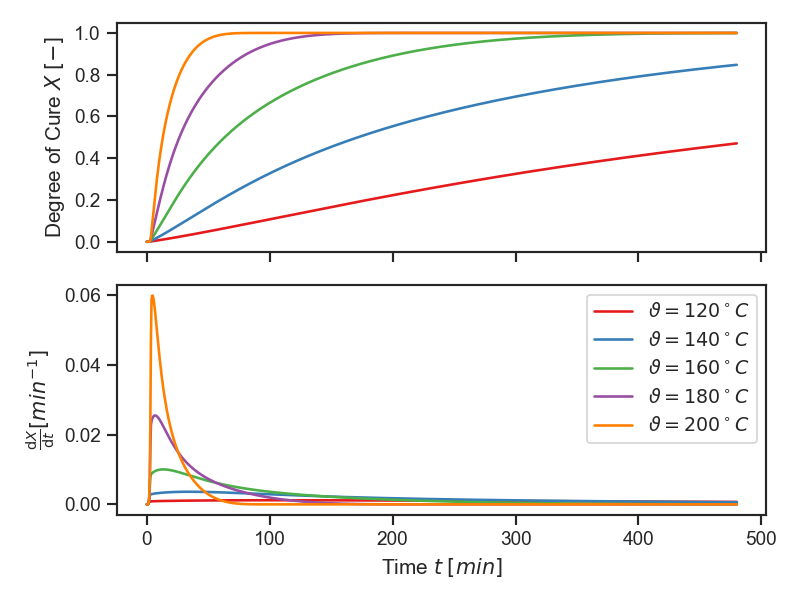

In [4]:
#### Modeling Parameters
# Degree of Cure at beginning
X0 = 0
# end time of simulation [s]
t_max = 8*3600
# Number of time steps
N = 1001
# evenly spaced time vector for output
t = np.linspace(0, t_max, N)
dt = t[1] - t[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Cure temperatures [°C]
for T in range(120, 201, 20):
    # Make an array for temperature of same length
    T_array = np.ones(N) * T

    #### Solve Partial Equation of Cure Reaction at time steps t
    X = odeint(reaction_model, X0, t, args=(np.array([t, T_array]), M21))
    X = np.ravel(X)
    label = r"$\vartheta = {} ^\circ C$".format(T)
    ax1.plot(t/60, X, label=label)
    
    dXdt = np.gradient(X) / dt * 60
    ax2.plot(t/60, dXdt, label=label)

plt.legend()
ax2.set_xlabel(labels["time"])
ax1.set_ylabel(labels["doc"])
ax2.set_ylabel(r"$\frac{\mathrm{d} X}{\mathrm{d} t} \left[ min^{-1} \right]$")
plt.tight_layout();

# Cure Modeling of DOW Airstone 880 (wind energy)

Following the models and parameters from Sven Ropte, DLR (Masterthesis):

> Sven Ropte (2016): _Einflussfaktoren auf Eigenspannungen und Verformungen in der Herstellung von Hauptgurten für Rotorblätter von Windkraftanlagen._ Masterthesis (Uni Magdeburg, DLR Braunschweig)

In [5]:
Airstone880 = dict(A1=np.exp(14.221), 
                   EA1=65045, 
                   A2=np.exp(10.349), 
                   EA2=44640, 
                   l=1.573, m=2.011, n=4.607,
                   a=0, b=-1e9)

<IPython.core.display.Javascript object>


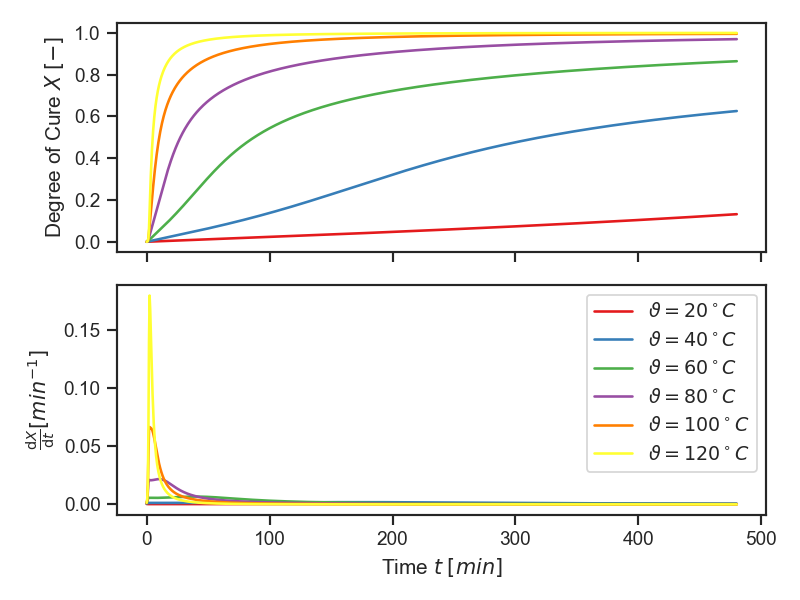

In [6]:
#### Modeling Parameters
# Degree of Cure at beginning
X0 = 0
# end time of simulation [s]
t_max = 8*3600
# Number of time steps
N = 1001
# evenly spaced time vector for output
t = np.linspace(0, t_max, N)
dt = t[1] - t[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Cure temperatures [°C]
for T in range(20, 121, 20):
    # Make an array for temperature of same length
    T_array = np.ones(N) * T

    #### Solve Partial Equation of Cure Reaction at time steps t
    X = odeint(reaction_model, X0, t, args=(np.array([t, T_array]), Airstone880))
    X = np.ravel(X)
    label = r"$\vartheta = {} ^\circ C$".format(T)
    ax1.plot(t/60, X, label=label)
    
    dXdt = np.gradient(X) / dt * 60
    ax2.plot(t/60, dXdt, label=label)

plt.legend()
ax2.set_xlabel(labels["time"])
ax1.set_ylabel(labels["doc"])
ax2.set_ylabel(r"$\frac{\mathrm{d} X}{\mathrm{d} t} \left[ min^{-1} \right]$")
plt.tight_layout();